In [3]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

Load Data 

In [4]:
# Load the training and testing dataset
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [6]:
# Define the list of all toxicity-related label columns
labels = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

#update new label if labels is 1
train_df['label'] = (train_df[labels].sum(axis=1) > 0).astype(int)


In [7]:
# Count the number of samples in each class label to check for class imbalance
train_df['label'].value_counts()

label
0    143346
1     16225
Name: count, dtype: int64

In [8]:
#cleaning (expand contractions, lowercase, strip non-letters)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

train_df['clean_text'] = train_df['comment_text'].apply(clean_text)
test_df ['clean_text'] = test_df ['comment_text'].apply(clean_text)

In [9]:
# Vectorize
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             max_df=0.9, min_df=5,
                             max_features=10000)
X = vectorizer.fit_transform(train_df['clean_text'])
y = train_df['label'].values

In [10]:
# Oversample with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [11]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42)

In [12]:
# Fit Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [13]:
#Get validation probabilities and apply threshold
y_val_prob   = nb.predict_proba(X_val)[:,1]          # score
threshold    = 0.7
y_val_label  = (y_val_prob >= threshold).astype(int) # final label


=== Validation @ threshold = 0.7 ===

              precision    recall  f1-score   support

           0       0.70      0.95      0.81     28441
           1       0.93      0.60      0.73     28898

    accuracy                           0.78     57339
   macro avg       0.82      0.78      0.77     57339
weighted avg       0.82      0.78      0.77     57339

Accuracy: 0.7764000069760547


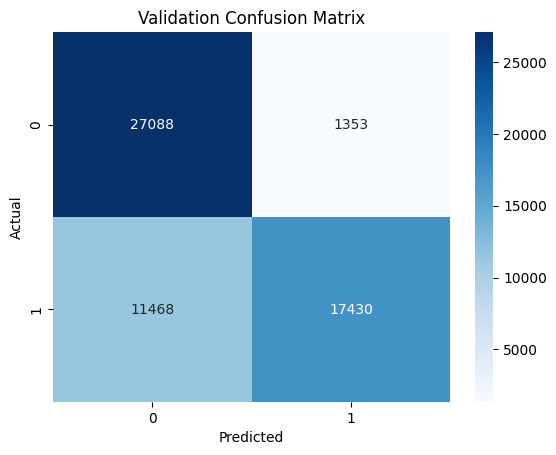

In [ ]:
# Evaluate
print("=== Validation @ threshold =", threshold, "===\n")
print(classification_report(y_val, y_val_label))
print("Accuracy:", accuracy_score(y_val, y_val_label))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_val_label)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

cm = confusion_matrix(y_val, y_val_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

In [15]:
# Score and predict on test set
X_test       = vectorizer.transform(test_df['clean_text'])
test_df['score']           = nb.predict_proba(X_test)[:,1]
test_df['predicted_label'] = (test_df['score'] >= threshold).astype(int)

In [17]:
# Load true test labels
testlabel_df = pd.read_csv('data/test_labels.csv')

# Keep only the rows that were actually scored (toxic != -1)
valid_labels = testlabel_df[testlabel_df['toxic'] != -1]

# Prepare predictions DataFrame
predictions_df = test_df[['id', 'predicted_label']].rename(columns={'predicted_label': 'label'})

# Merge on 'id' to align predictions with true labels
merged = pd.merge(predictions_df, valid_labels[['id', 'toxic']], on='id')

# Evaluate
print("=== Test Set Evaluation ===")
print(classification_report(merged['toxic'], merged['label']))
print("Accuracy:", accuracy_score(merged['toxic'], merged['label']))


=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     57888
           1       0.48      0.76      0.59      6090

    accuracy                           0.90     63978
   macro avg       0.73      0.84      0.77     63978
weighted avg       0.93      0.90      0.91     63978

Accuracy: 0.9002469598924631
